In [ ]:
%matplotlib inline

In [ ]:
from fastai2.vision.all import *
from nbdev.showdoc import *

set_seed(2)

# Create databunch

In [ ]:
bs=64

In [ ]:
path = untar_data(URLs.PETS); path

PosixPath('/home/quantran/.fastai/data/oxford-iiit-pet')

In [ ]:
path.ls()

(#2) [/home/quantran/.fastai/data/oxford-iiit-pet/annotations,/home/quantran/.fastai/data/oxford-iiit-pet/images]

In [ ]:
Path.BASE_PATH = path # display all paths relative to dataset root
path.ls()

(#2) [/home/quantran/.fastai/data/oxford-iiit-pet/annotations,/home/quantran/.fastai/data/oxford-iiit-pet/images]

In [ ]:
path_anno = path/'annotations'
path_img = path/'images'

In [ ]:
fnames = get_image_files(path_img)

In [ ]:
print(fnames[:10]),type(fnames)

(#10) [/home/quantran/.fastai/data/oxford-iiit-pet/images/chihuahua_57.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/shiba_inu_20.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/Abyssinian_96.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/British_Shorthair_2.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/german_shorthaired_115.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/beagle_201.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_164.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/beagle_47.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_81.jpg,/home/quantran/.fastai/data/oxford-iiit-pet/images/japanese_chin_117.jpg]


(None, fastcore.foundation.L)

In [ ]:
crop_func = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))

dbunch = ImageDataBunch.from_name_re(
    path, 
    fnames, 
    pat=r'(.+)_\d+.jpg$', 
    item_tfms=crop_func, # for after_item: item-by-item transformation
    bs=bs,
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
    # for after_batch: transformation for whole batch. Done on GPU
)

In [ ]:
??aug_transforms ## ~ to get_transforms(). Can add xtra_tfms for new tfms

In [ ]:
len(dbunch.train_ds),len(dbunch.valid_ds)

(5912, 1478)

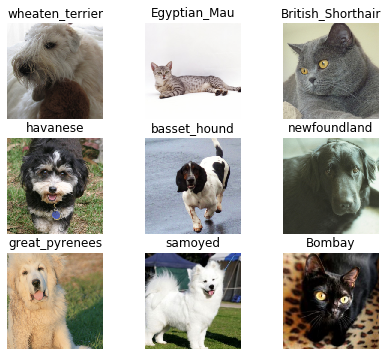

In [ ]:

dbunch.show_batch(max_n=9, figsize=(7,6))

In [ ]:
print(dbunch.vocab)
len(dbunch.vocab),dbunch.c

(#37) [Abyssinian,Bengal,Birman,Bombay,British_Shorthair,Egyptian_Mau,Maine_Coon,Persian,Ragdoll,Russian_Blue...]


(37, 37)

# Training

In [ ]:
learn = cnn_learner(dbunch, resnet34, metrics=error_rate).to_fp16()

In [ ]:

learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.915851,0.394836,0.127875,00:21
1,0.653686,0.289016,0.087957,00:22
2,0.386969,0.271419,0.085250,00:21
3,0.288454,0.267483,0.087280,00:22


In [ ]:
learn.save('stage-1')

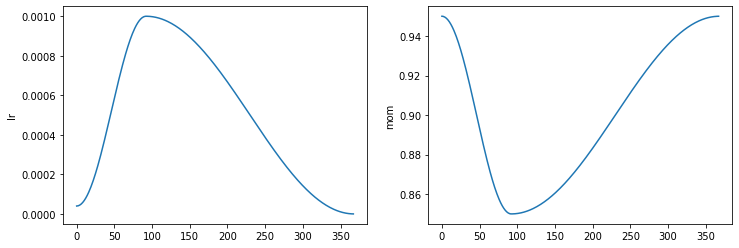

In [ ]:
learn.recorder.plot_sched()

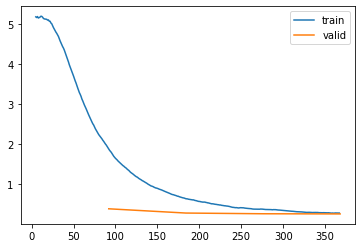

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.loss_func # flattened of (log loss on softmax)

FlattenedLoss of CrossEntropyLoss()

# Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn) # on val set

losses,idxs = interp.top_losses() # log loss and img idxs, sorted

len(dbunch.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
my_loss=losses[3]
my_idx = idxs[3]
my_loss,my_idx

(tensor(6.6045), tensor(567))

In [ ]:
interp.targs[my_idx],dbunch.vocab[interp.targs[my_idx]] # actual class of this img

(tensor(16), 'boxer')

In [ ]:
interp.preds[my_idx]

tensor([4.5664e-05, 5.3858e-05, 2.0238e-07, 4.6218e-06, 1.0396e-05, 3.0148e-06,
        4.4987e-07, 9.3963e-06, 5.2552e-06, 1.0378e-06, 8.7224e-07, 3.5813e-04,
        9.9314e-01, 1.1051e-04, 9.2515e-05, 2.1895e-03, 1.3542e-03, 5.6059e-05,
        7.4048e-05, 1.0579e-05, 4.5964e-07, 3.7673e-05, 6.4272e-05, 1.7763e-04,
        1.8885e-06, 5.4584e-07, 5.0317e-06, 1.6266e-05, 1.1465e-06, 1.6633e-06,
        1.9398e-03, 5.0588e-06, 2.7025e-06, 1.2304e-04, 8.0536e-05, 3.3079e-06,
        2.0896e-05])

In [ ]:
sum(interp.preds[my_idx]) # preds already softmax

tensor(1.0000)

In [ ]:
interp.preds[my_idx].max(),interp.preds[my_idx].argmax() # predict prob and predict idx

(tensor(0.9931), tensor(12))

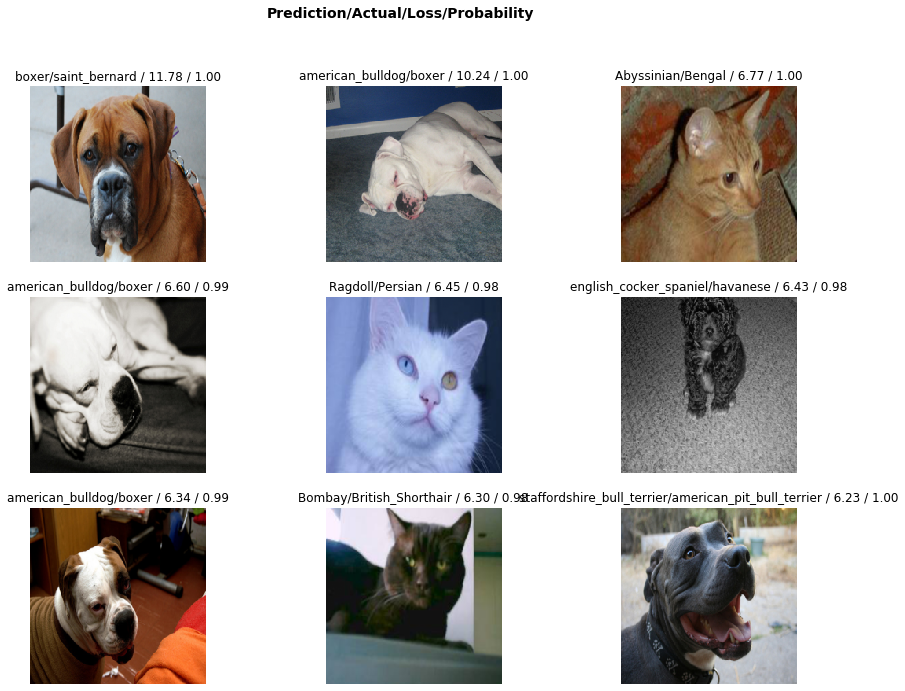

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))
# 4th picture

# Unfreeze train

In [ ]:
learn.load('stage-1');

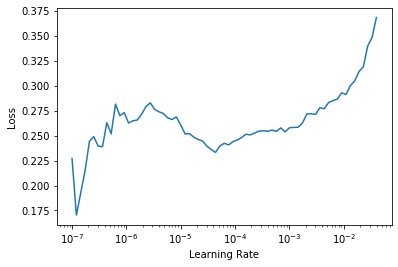

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.258799,0.256039,0.081867,00:27
1,0.241469,0.250523,0.081191,00:27


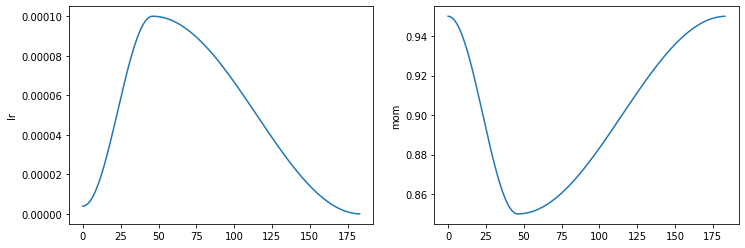

In [ ]:
learn.recorder.plot_sched()

In [ ]:
??DataBlock